# Data Analysis

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [328]:
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
blue = '#7995c4'

Something here, just make pretty later

In [329]:
orgs_df = pd.read_csv('clean_data/organizations.csv').drop(columns='Unnamed: 0')
people_df = pd.read_csv('clean_data/people.csv').drop(columns='Unnamed: 0')
rounds_df = pd.read_csv('clean_data/rounds.csv').drop(columns='Unnamed: 0')

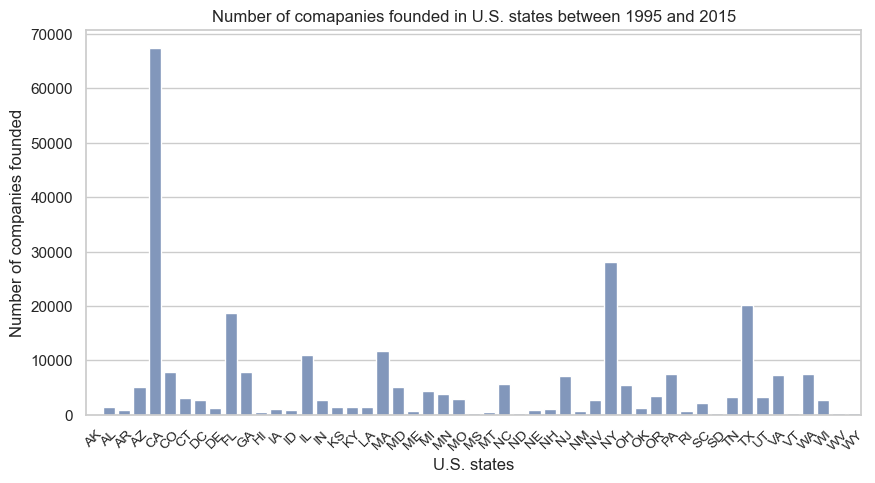

In [330]:
# Create a bar plot for companies per state

to_plot_states = orgs_df.groupby(by='state_code').count().reset_index()[['state_code','uuid']][1:]
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax = sns.barplot(x="state_code", y="uuid", data=to_plot_states,color=blue)
ax.set_xticklabels(to_plot_states["state_code"],rotation=45,fontsize=10)

ax.set_ylabel('Number of companies founded')
ax.set_xlabel('U.S. states')
ax.set_title('Number of comapanies founded in U.S. states between 1995 and 2015')

plt.show()

In [331]:
# Get only companies in California
orgs_df = orgs_df[orgs_df['state_code'] == 'CA'].drop(columns='state_code').rename(columns={'uuid':'org_uuid'})

# The companies that have a nan-entry in Series B have not gone through this round
cond = rounds_df['investment_type_series_b'].fillna(False).astype(bool)
series_b = rounds_df[cond][['org_uuid','investment_type_series_b']]

# Add a series_B column to orgs_df
orgs_df = orgs_df.merge(series_b,how='left',on='org_uuid')
orgs_df['investment_type_series_b'] = orgs_df['investment_type_series_b'].fillna(False).astype(bool)


# Define what success mean in our experiment
cond1 = (orgs_df['status'] == 'acquired') | (orgs_df['status'] == 'ipo')
cond2 = (orgs_df['status'] == 'operating') & orgs_df['investment_type_series_b']
orgs_df['success'] = cond1 | cond2


In [332]:
num_sucessful = orgs_df['success'].sum()
num_failed = orgs_df['success'].count() - num_sucessful

print(f'There is a total of {num_sucessful + num_failed} of companies founded in california between 1995 and 2015')
print(f'Out of that number, {num_sucessful} companies were successful while {num_failed} failed')

There is a total of 67469 of companies founded in california between 1995 and 2015
Out of that number, 8569 companies were successful while 58900 failed


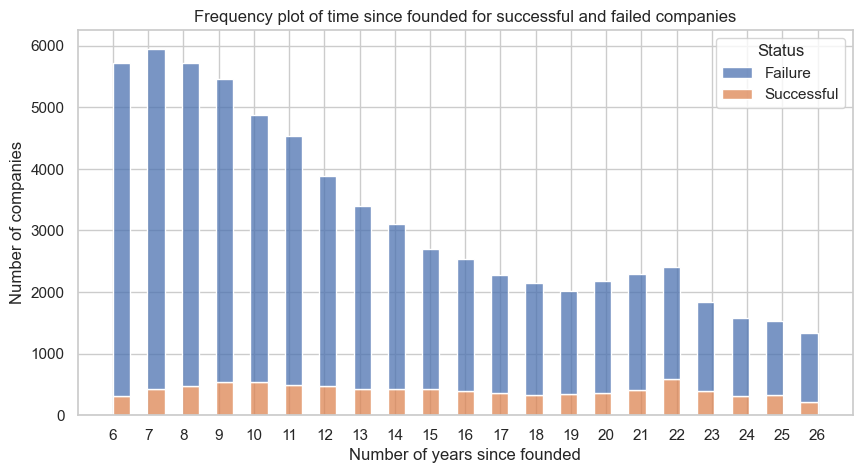

In [336]:
# plot graphs of company success since founded
orgs_df['founded_on'] = pd.to_datetime(orgs_df['founded_on'])
to_plot = orgs_df[['org_uuid','founded_on','success']] 

to_plot['years_since_found'] = (2021 - to_plot['founded_on'].dt.year).astype(int)
to_plot['Status'] = to_plot['success'].map(lambda x: 'Successful' if x else 'Failure')

# Absolute histogram
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax = sns.histplot(x="years_since_found",data=to_plot,multiple="stack",hue='Status')
ax.set_xticks(range(6,27))

ax.set_ylabel('Number of companies')
ax.set_xlabel('Number of years since founded')
ax.set_title('Frequency plot of time since founded for successful and failed companies')

plt.show()

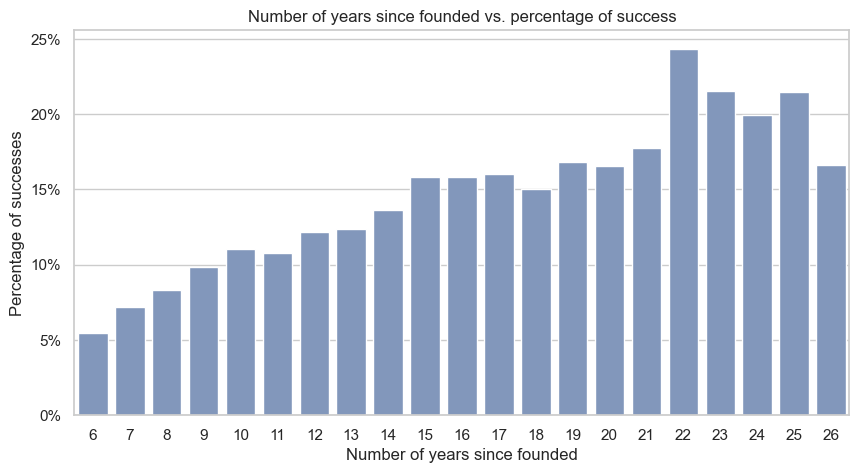

In [337]:

# Get proportions of success per year so we can plot
temp = to_plot[['years_since_found','Status','org_uuid']].groupby(by=['years_since_found','Status'],).count()
totals = temp.groupby(level=0).sum().reset_index().rename(columns={'org_uuid':'count_total'})
success = temp.loc[(slice(None),'Successful'),:].reset_index().drop(columns='Status').rename(columns={'org_uuid':'count_succ'})
to_plot = success.merge(totals,how='inner',on='years_since_found') 
to_plot['proportion_success'] = to_plot['count_succ'] / to_plot['count_total']

# relative histogram
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax = sns.barplot(x="years_since_found",y='proportion_success',data=to_plot,color=blue)

ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%', '25%'])
ax.set_ylabel('Percentage of successes')
ax.set_xlabel('Number of years since founded')
ax.set_title('Number of years since founded vs. percentage of success')

plt.show()

In [372]:
# Plot graphs for category groups

temp = orgs_df['category_groups_list'].map(lambda entry: str(entry).split(','))
temp = pd.get_dummies(temp.apply(pd.Series).stack()).sum(level=0).iloc[:,:-1]

In [387]:
to_plot = pd.DataFrame(temp.sum(axis=0), columns=['categories', 'groups']

SyntaxError: unexpected EOF while parsing (<ipython-input-387-ab58a9ad5d9b>, line 1)

In [388]:
type(to_plot

SyntaxError: unexpected EOF while parsing (<ipython-input-388-1702d82d7138>, line 1)

In [389]:
# Create a bar plot for companies per category



fig, ax = plt.subplots(1,1, figsize=(10,5))

ax = sns.barplot(x="state_code", y="uuid", data=to_plot_states,color=blue)
ax.set_xticklabels(to_plot_states["state_code"],rotation=45,fontsize=10)

ax.set_ylabel('Number of companies founded')
ax.set_xlabel('U.S. states')
ax.set_title('Number of comapanies founded in U.S. states between 1995 and 2015')

plt.show()

ValueError: Could not interpret input 'state_code'

In [371]:
orgs_df

,org_uuid,status,category_list,category_groups_list,founded_on,last_funding_on,investment_type_series_b,success
0,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,operating,"Cloud Computing,Collaboration,CRM,Developer To...","Administrative Services,Information Technology...",1996-09-15,NaN,False,False
1,df662812-7f97-0b43-9d3e-12f64f504fbb,ipo,"Mobile Apps,Photo Sharing,Social Media,Social ...","Apps,Content and Publishing,Internet Services,...",2004-02-04,2014-10-20,True,True
2,60485007-8856-bbac-aa1b-c535c41f5f47,closed,"E-Commerce,File Sharing,Internet,Social Media,...","Commerce and Shopping,Internet Services,Media ...",2005-11-01,2006-12-01,False,False
3,4111dc8b-c0df-2d24-ed33-30cd137b3098,acquired,"Collaboration,Communities","Community and Lifestyle,Other",2006-06-01,2009-01-19,False,True
4,180ebf67-68d0-2316-e93d-8e1e546330ba,acquired,"Mobile,News,Photography,Software,Video","Content and Publishing,Media and Entertainment...",2006-01-01,NaN,False,True
...,...,...,...,...,...,...,...,...
67464,4e5f0145-5f15-4c01-b058-1f20c43831d2,operating,"Financial Services,Marketing,Public Relations","Financial Services,Sales and Marketing",2012-01-01,NaN,False,False
67465,30639c50-83be-4671-9877-fd3b37b4cbd0,operating,"Finance,Financial Services,Lending",Financial Services,1995-01-01,NaN,False,False
67466,074fcef4-787d-445a-9790-bb8c5c1998f8,operating,"Graphic Design,Mobile Apps,Software,Web Design","Apps,Design,Mobile,Software",2002-01-01,NaN,False,False
67467,118af019-6af0-46d1-8774-67ccd757b3c2,operating,"Beauty,Commercial,Cosmetics,E-Commerce","Commerce and Shopping,Consumer Goods,Other",2014-01-01,NaN,False,False
